In [1]:
import pandas as pd
import os
import talib
import matplotlib.pyplot as plt
import pynance as pn

In [2]:
financial_news = pd.read_csv('../Data/cleaned_financial_news.csv')
financial_news['date'] = pd.to_datetime(financial_news['date'])
financial_news.head()

,headline,url,publisher,date,stock,headline_length
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 14:30:54+00:00,A,39
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 14:45:20+00:00,A,42
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 08:30:07+00:00,A,29
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 16:45:06+00:00,A,44
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 15:38:59+00:00,A,87


In [3]:
financial_news.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407327 entries, 0 to 1407326
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   headline         1407327 non-null  object             
 1   url              1407327 non-null  object             
 2   publisher        1407327 non-null  object             
 3   date             1407327 non-null  datetime64[ns, UTC]
 4   stock            1407327 non-null  object             
 5   headline_length  1407327 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 64.4+ MB


Load Allstock Files

In [4]:
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']

In [6]:
company_data = {}

# Loop through each company's CSV file and store it in a dictionary
for ticker in tickers:
    file_path = f'../Data/yfinance_data/{ticker}_historical_data.csv'
    company_data[ticker] = pd.read_csv(file_path)
    company_data[ticker]['Date'] = pd.to_datetime(company_data[ticker]['Date'])  # Ensure date is datetime


In [7]:
## Check the data
company_data['AAPL'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000,0.0,0.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600,0.0,0.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600,0.0,0.0


Calculate Technical Indicators Using TA-Lib

In [8]:
for ticker, df in company_data.items():
    df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
    df['EMA_200'] = talib.EMA(df['Close'], timeperiod=200)
    df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    company_data[ticker] = df

# Display the first few rows for one company
print(company_data['AAPL'].head())


        Date      Open      High       Low     Close  Adj Close     Volume  \
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits  SMA_50  EMA_200  RSI_14  MACD  MACD_signal  \
0        0.0           0.0     NaN      NaN     NaN   NaN          NaN   
1        0.0           0.0     NaN      NaN     NaN   NaN          NaN   
2        0.0           0.0     NaN      NaN     NaN   NaN          NaN   
3        0.0           0.0     NaN      NaN     NaN   NaN          NaN   
4        0.0           0.0     NaN      NaN     NaN   NaN          NaN   

   MACD_hist  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        Na


Calculate Financial Metrics Using PyNance

In [9]:
# Calculate volatility (rolling standard deviation of returns) for each company's data
for ticker, df in company_data.items():
    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change()
    # Calculate rolling 30-day volatility (standard deviation of returns)
    df['Volatility'] = df['Returns'].rolling(window=30).std() * (252 ** 0.5)  # Annualized
    company_data[ticker] = df

# Display the updated data for one company
print(company_data['GOOG'].head())

        Date      Open      High       Low     Close  Adj Close     Volume  \
0 2004-08-19  2.490664  2.591785  2.390042  2.499133   2.496292  897427216   
1 2004-08-20  2.515820  2.716817  2.503118  2.697639   2.694573  458857488   
2 2004-08-23  2.758411  2.826406  2.716070  2.724787   2.721690  366857939   
3 2004-08-24  2.770615  2.779581  2.579581  2.611960   2.608991  306396159   
4 2004-08-25  2.614201  2.689918  2.587302  2.640104   2.637103  184645512   

   Dividends  Stock Splits  SMA_50  EMA_200  RSI_14  MACD  MACD_signal  \
0        0.0           0.0     NaN      NaN     NaN   NaN          NaN   
1        0.0           0.0     NaN      NaN     NaN   NaN          NaN   
2        0.0           0.0     NaN      NaN     NaN   NaN          NaN   
3        0.0           0.0     NaN      NaN     NaN   NaN          NaN   
4        0.0           0.0     NaN      NaN     NaN   NaN          NaN   

   MACD_hist   Returns  Volatility  
0        NaN       NaN         NaN  
1        NaN

Visualize Data for Multiple Companies

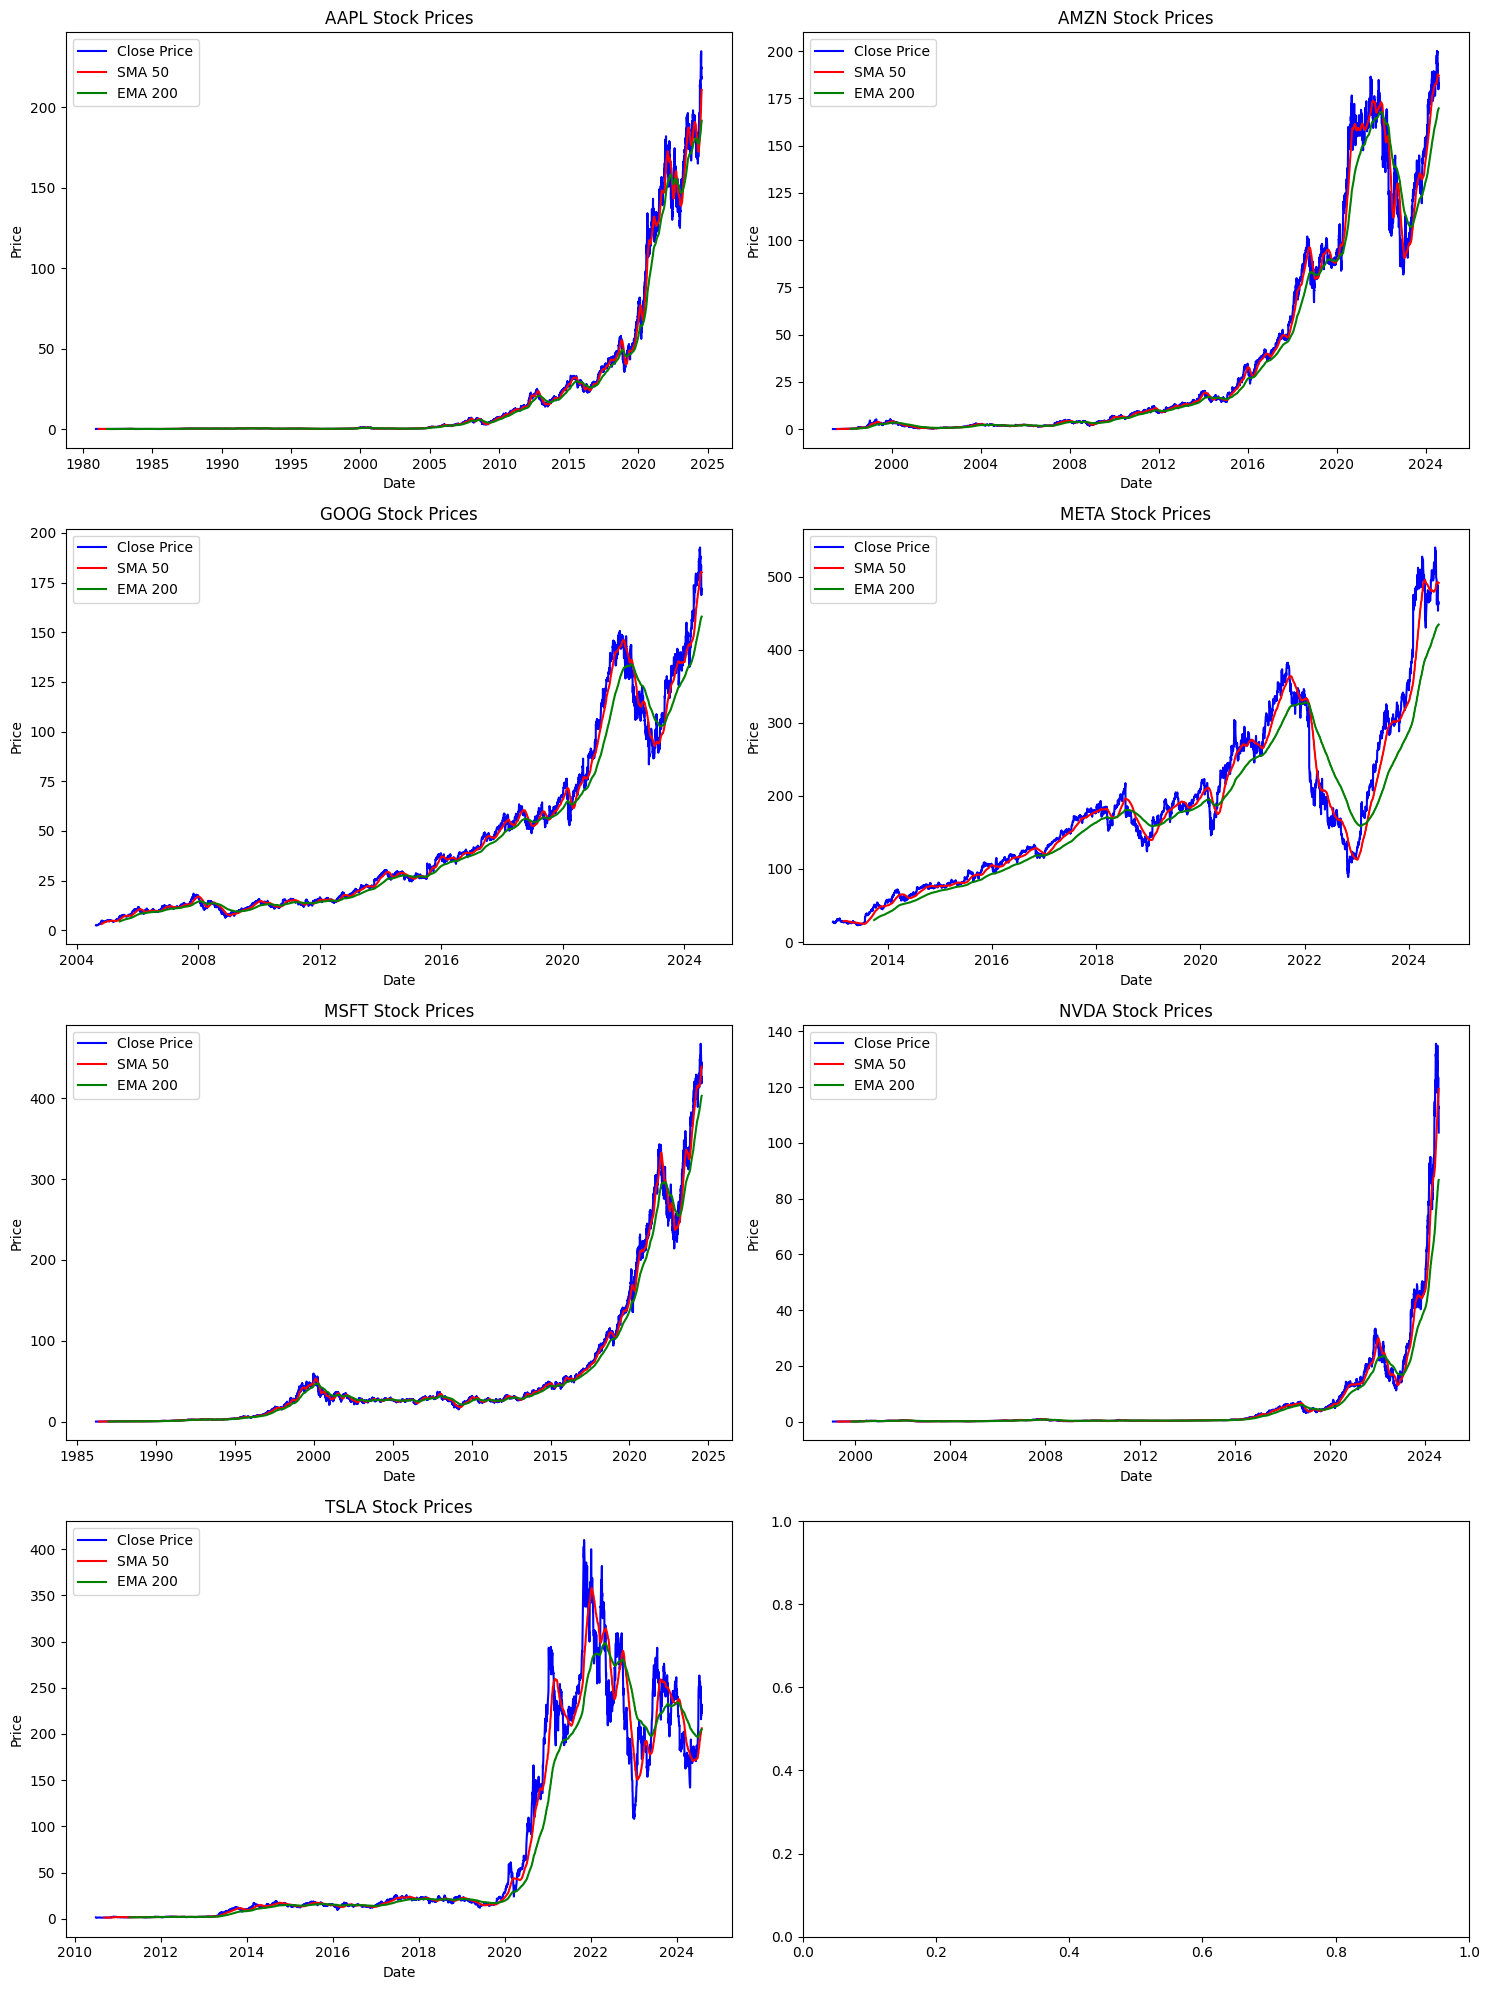

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))  # 4 rows, 2 columns for 7 companies

for i, ticker in enumerate(tickers):
    ax = axes.flatten()[i]
    df = company_data[ticker]
    ax.plot(df['Date'], df['Close'], label='Close Price', color='blue')
    ax.plot(df['Date'], df['SMA_50'], label='SMA 50', color='red')
    ax.plot(df['Date'], df['EMA_200'], label='EMA 200', color='green')
    ax.set_title(f'{ticker} Stock Prices')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()

plt.tight_layout()
plt.show()